## Examine network characteristics (distance, centrality)  

#### Here we begin to examine the social network for each season and compare them in longitudinal order.
####The questions and methods explored in this notebook include:  
  
* Are the network distance and shape changing over time?  
* What is the relation between network centrality and a player's final placement?  
* How does the centrality of winners compare over time?

### Load data and modules

In [1]:
# Force automatic reload of external functions
# see http://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython import display as dis
%matplotlib inline

%aimport -pd
%aimport -pickle
%aimport -plt
%aimport -dis

# import numpy as np
# import networkx as nx

In [2]:
# %load https://gist.github.com/ajp619/ddaa0f35627b066ef528/raw/cbbd6c6c1cad286ba5a358b93fd94eddede7c4ba/qtutil.py
# silly utility to launch a qtconsole if one doesn't exist

consoleFlag = True
consoleFlag = False  # Turn on/off by commenting/uncommenting this line

import psutil

def returnPyIDs():
    pyids = set()
    for pid in psutil.pids():
        try:
            if "python" in psutil.Process(pid).name():
                pyids.add(pid)
        except:
            pass
    return pyids

def launchConsole():
    before_pyids = returnPyIDs()
    %qtconsole
    after_pyids = returnPyIDs()
    newid = after_pyids.difference(before_pyids)
    assert len(newid) == 1
    return list(newid)[0]

try:
    print qtid
except NameError:
    if consoleFlag:
        qtid = launchConsole()
        print qtid
    
if consoleFlag and (qtid not in returnPyIDs()):
    qtid = launchConsole()
    print qtid

In [3]:
graphs = pickle.load( open("make_graphs.p", "rb" ) )
seasons = pickle.load( open("wiki_scrape.p", "rb" ) )
voteweights = pickle.load( open("process_votes.p", "rb" ) )

In [4]:
# Season numbering
snums = pd.DataFrame({'season': seasons.keys(),
                      'season_num': [seasons[i]['num'] 
                                     for i in seasons.keys()]})

snums = snums.sort_values('season_num')
snums

,season,season_num
2,Borneo,1
9,The_Australian_Outback,2
26,Africa,3
6,Marquesas,4
14,Thailand,5
15,The_Amazon,6
7,Pearl_Islands,7
24,All-Stars,8
8,Vanuatu,9
0,Palau,10


### Calculate distance and centrality measures

In [5]:
%%writefile network.py

import pandas as pd
import numpy as np
import networkx as nx
import pickle

# Build pandas df of all centrality scores
# Degree, closeness, betweenness, eigenvector, pagerank

def distance_scores(season, graph):
    
    # Take largest connected component
    g = graph if nx.is_connected(graph) else max(nx.connected_component_subgraphs(graph), key=len)
    
    # Ratio of largest connected component subgraph
    conn = len(max(nx.connected_component_subgraphs(g), key=len)) / float(nx.number_of_nodes(graph))
    conn = np.round(conn, 3)
    
    # Radius, diameter
    rad = nx.radius(g)
    diam = nx.diameter(g)
    
    # Average eccentricity
    ecc = np.mean(nx.eccentricity(g).values())
    ecc = np.round(ecc, 3)
    
    # Put it all into a dataframe
    df = pd.DataFrame([[season,conn,rad,diam,ecc]], columns=['season', 'conn', 'rad', 'diam', 'ecc'])
    
    return df

def centrality_scores(vote_matrix, season_graph):
    deg = nx.degree(season_graph)
    deg = {k: round(v,1) for k,v in deg.iteritems()}

    close = nx.closeness_centrality(season_graph)
    close = {k: round(v,3) for k,v in close.iteritems()}

    btw = nx.betweenness_centrality(season_graph)
    btw = {k: round(v,3) for k,v in btw.iteritems()}

    eig = nx.eigenvector_centrality_numpy(season_graph)
    eig = {k: round(v,3) for k,v in eig.iteritems()}
    
    page = nx.pagerank(season_graph)
    page = {k: round(v,3) for k,v in page.iteritems()}

    # Add contestant placement (rank)
    order = list(vote_matrix.index)
    place_num = list(range(len(order)))
    place = {order[i]:i+1 for i in place_num}
    
    names = season_graph.nodes()

    # Build a table with centralities 
    table=[[name, deg[name], close[name], btw[name], eig[name], page[name], place[name]] for name in names]

    # Convert table to pandas df
    headers = ['name', 'deg', 'close', 'btw', 'eig', 'page', 'place']
    df = pd.DataFrame(table, columns=headers)
    df = df.sort_values(['page', 'eig', 'deg'], ascending=False)
    
    return df

def get_all_centrality_scores(voteweights, graphs, save_to_disk=True):
    central = {s: centrality_scores(voteweights[s], graphs[s]) 
               for s in graphs.keys()}
    if save_to_disk:
        pickle.dump( central, open( "network.p", "wb" ) )
    return central

Overwriting network.py


In [6]:
from network import *

## Network Distance
* Maximum connected components (as a percent of total nodes)  
* Radius  
* Diameter  
* Average eccentricity

array([<matplotlib.axes.AxesSubplot object at 0x108e3b210>,
       <matplotlib.axes.AxesSubplot object at 0x108fe7190>], dtype=object)

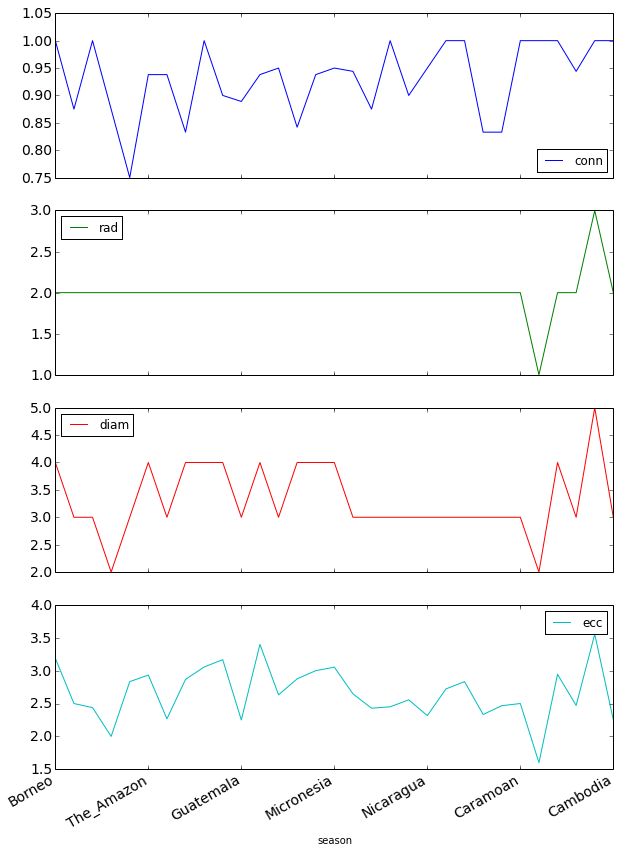

In [7]:
d = [distance_scores(s, graphs[s]) for s in graphs.keys()]
distance = pd.concat(d)
distance = distance.merge(snums)
distance = distance.sort_values(['season_num'])

distance.plot(x="season", 
             y=['conn', 'rad', 'diam', 'ecc'], 
             subplots=True,
             figsize=(10,15),
             fontsize=14)

>There is not much change in shape or distance between seasons or over time. This is probably expected due to the small number of nodes per network (16-20). Also, network distance and shape do not account for edge weights, which is where most of the actual game dynamics reside. Node centrality measures should be more effective at discerning this.

## Node centrality  
* Degrees  
* Closeness  
* Betweenness  
* Eigenvector  
* PageRank

In [8]:
# Calculate centrality for all seasons
central = get_all_centrality_scores(
    voteweights, graphs, save_to_disk=True
)

In [9]:
graphs.keys()

[u'Palau',
 u'Tocantins',
 u'Borneo',
 u'Panama',
 u'Cambodia',
 u'Blood_vs._Water',
 u'Marquesas',
 u'Pearl_Islands',
 u'Vanuatu',
 u'The_Australian_Outback',
 u'Heroes_vs_Villains',
 u'Guatemala',
 u'China',
 u'Worlds_Apart',
 u'Thailand',
 u'The_Amazon',
 u'Cagayan',
 u'South_Pacific',
 u'One_World',
 u'Philippines',
 u'Caramoan',
 u'Gabon',
 u'Micronesia',
 u'Samoa',
 u'All-Stars',
 u'Nicaragua',
 u'Africa',
 u'San_Juan_del_Sur',
 u'Cook_Islands',
 u'Redemption_Island',
 u'Fiji']

In [10]:
# Borneo example, sorted by pagerank
example = 'Borneo'
centrality_scores(voteweights[example], graphs[example])

,name,deg,close,btw,eig,page,place
14,Rudy,6,0.600,0.026,0.507,0.108,3
4,Susan,6,0.600,0.026,0.493,0.105,4
2,Richard,6,0.600,0.026,0.469,0.095,1
5,Kelly,8,0.652,0.271,0.354,0.093,2
13,Colleen,7,0.625,0.095,0.034,0.090,6
8,Jenna,11,0.789,0.405,0.093,0.087,8
11,Sean,6,0.600,0.026,0.359,0.074,5
0,Gervase,6,0.556,0.010,0.015,0.067,7
12,Gretchen,6,0.556,0.010,0.017,0.061,10
6,Joel,5,0.517,0.000,0.012,0.051,11


### Placement vs. Centrality
**x-axis = placement (rank)**  
**y-axis = centrality measure**

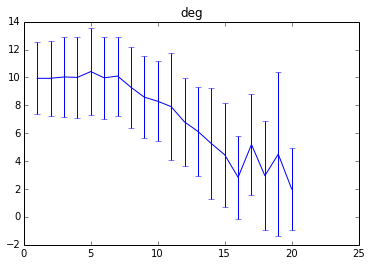

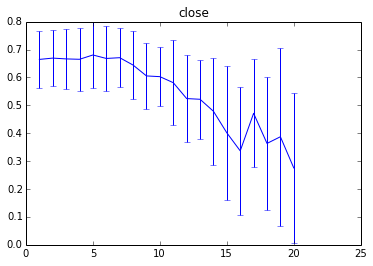

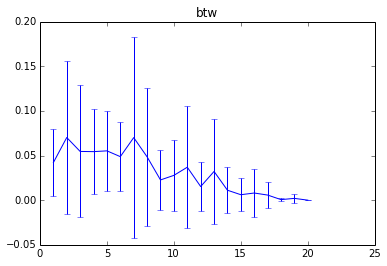

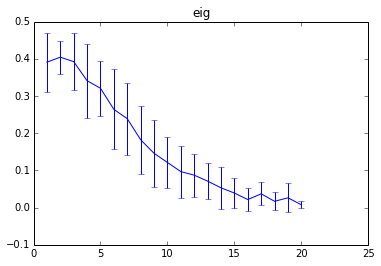

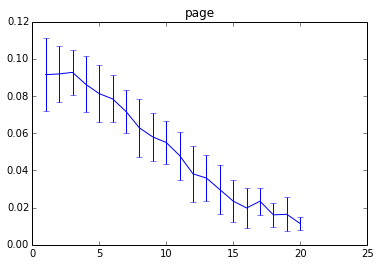

In [11]:
df = pd.DataFrame()
for i in central.keys():
    df = df.append(central[i])
    
grouped = df.groupby(['place'])
dfMean = grouped.mean()
dfStd = grouped.std()

for c in dfMean.columns:
    plt.errorbar(dfMean.index.values, dfMean[c].values, dfStd[c].values)
    plt.title(c)
    plt.show()

> These results are interesting. Clearly higher finishers have higher degrees and closeness scores. This makes sense since they are in the game longer and have more chances to make connections. Conversely, their close connections may be why they finish higher.  

> Betweeness seems to level off into two tiers that are split around the 8th place finisher. The most plausible conclusion is this is the point of the game when the tribes merge. This technically creates first opportunites for new players to vote together.  
  
> The eigenvector and pagerank scores have a distinct downwards trend. Since these are more comprehensive scores that take into account the other centrality measures, it seems evident that the top players do occupy a more central position in the network. One interesting finding is the small uptick around the 3rd and 4th place finisher. It's unclear whether this is an actual trend or a bias based on specific game dynamics and resulting edge weight calculations.

## Winner analysis

In [12]:
# Test structure
winner_example = central['Borneo']
winner_example[winner_example['place'] == 1]

,name,deg,close,btw,eig,page,place
2,Richard,6,0.6,0.026,0.469,0.095,1


In [13]:
# Create winners dataframe
winner_list = [central[i][central[i]['place']==1] for i in central.keys()]
winners = pd.concat(winner_list).reset_index(drop=True)

# Add season and season_num; Drop place since all 1's
winners['season'] = central.keys()
winners = winners.merge(snums)
winners.drop('place', 1, inplace=True)
winners = winners.sort_values(['season_num'])
winners

,name,deg,close,btw,eig,page,season,season_num
2,Richard,6,0.600,0.026,0.469,0.095,Borneo,1
9,Tina,9,0.663,0.072,0.472,0.106,The_Australian_Outback,2
26,Ethan,10,0.750,0.023,0.449,0.112,Africa,3
6,Vecepia,10,0.704,0.028,0.438,0.120,Marquesas,4
14,Brian,6,0.403,0.005,0.489,0.090,Thailand,5
15,Jenna,9,0.688,0.041,0.397,0.110,The_Amazon,6
7,Sandra,9,0.688,0.024,0.418,0.100,Pearl_Islands,7
24,Amber,9,0.576,0.065,0.449,0.108,All-Stars,8
8,Chris,11,0.739,0.136,0.282,0.091,Vanuatu,9
0,Tom,8,0.563,0.018,0.406,0.072,Palau,10


array([<matplotlib.axes.AxesSubplot object at 0x10c26fdd0>,
       <matplotlib.axes.AxesSubplot object at 0x10c4a0790>], dtype=object)

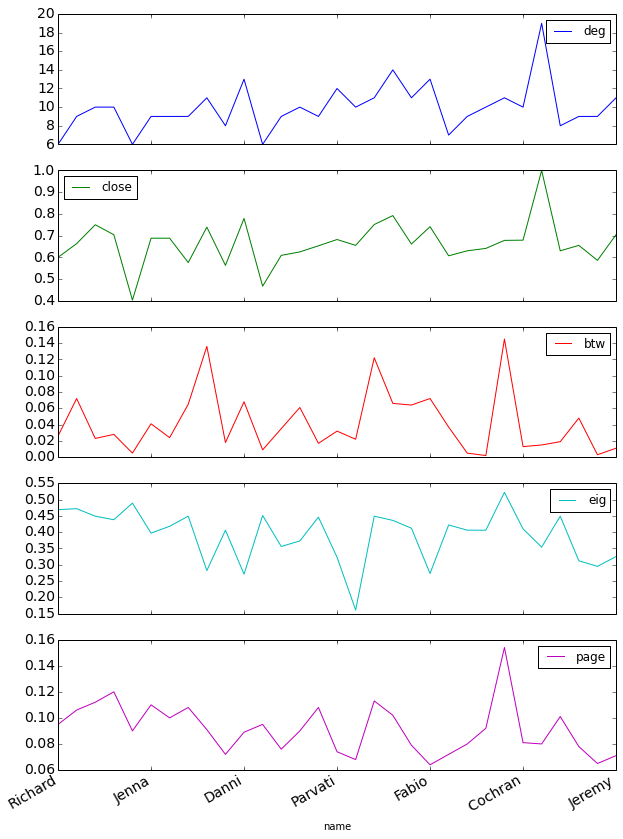

In [14]:
winners.plot(x="name", 
             y=['deg', 'close', 'btw', 'eig', 'page'], 
             subplots=True,
             figsize=(10,15),
             fontsize=14)

> There doesn't seem to be any apparent directional trends for winners over time. However, there is some noticeable variation for each centrality measure. This probably means that although winners have higher centrality overall, there are several winning strategy network positions. In fact, the somewhat cyclical trend of the eigenvector and PageRank scores may show that copying the most recent winner's position is not beneficial.